In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from keras.applications.vgg19 import VGG19
%matplotlib inline

In [2]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 224

vgg = VGG19(weights='imagenet')
print(vgg.summary())

vgg.trainable = False
pp.pprint(vgg)

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


In [4]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 14, 14, 512) dtype=float32 (created by layer 'block5_conv4')>

In [5]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [6]:
def compute_content_cost(content_output, generated_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]


    _, n_H, n_W, n_C = a_G.get_shape().as_list()



    a_C_unrolled = tf.reshape(a_C, shape=[_, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[_, n_H * n_W, n_C])



    J_content = (tf.reduce_sum(tf.math.square(tf.subtract(a_C_unrolled,a_G_unrolled))))/(4*n_H*n_W*n_C)

    return J_content

In [7]:
def gram_matrix(A):

    GA = tf.matmul(A,tf.transpose(A))

    return GA

In [8]:
def compute_layer_style_cost(a_S, a_G):

    _, n_H, n_W, n_C = a_G.get_shape().as_list()



    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])


    a_S = tf.transpose(a_S)
    a_G = tf.transpose(a_G)


    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(GS - GG))

    return J_style_layer / (4.0 * (n_H * n_W * n_C) ** 2)

In [9]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):



    J_style = 0

    a_S = style_image_output[:-1]


    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):

        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [10]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha* J_content + beta * J_style
    return J

(1, 224, 224, 3)


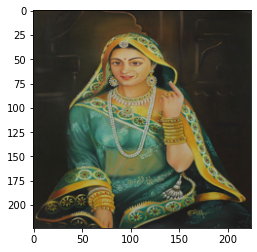

In [11]:

content_image = np.array(Image.open("content2.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 224, 224, 3)


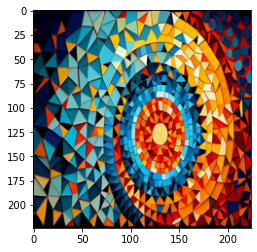

In [12]:
style_image =  np.array(Image.open("pattern2.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 224, 224, 3)


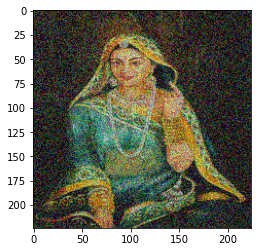

In [13]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [14]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    print(model)
    return model

In [15]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [16]:
content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

In [17]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [18]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [19]:
def clip_0_1(image):

    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [20]:
total_loss = np.array([], dtype=np.float64)
content_loss= np.array([], dtype=np.float64)
style_loss = np.array([], dtype=np.float64)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:

        a_G = vgg_model_outputs(generated_image)


        J_style = compute_style_cost(a_S,a_G, STYLE_LAYERS=STYLE_LAYERS)


        J_content = compute_content_cost(a_C, a_G)

        J = total_cost(J_content, J_style, alpha = 10, beta = 30)





    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J,J_content,J_style


Epoch 0 
74722.9296875 ,0.014008402824401855,2490.759521484375


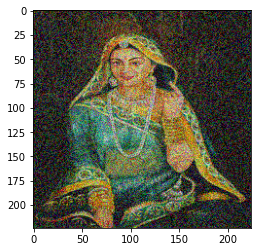

Epoch 500 
80.30392456054688 ,0.020284166559576988,2.6700360774993896


KeyboardInterrupt: 

In [23]:
generated_image = tf.Variable(generated_image)
epochs = 2501
for i in range(epochs):
    J, J_content, J_style=train_step(generated_image)
    total_loss=np.append(total_loss,J)
    content_loss=np.append(content_loss,J_content)
    style_loss=np.append(style_loss,J_style)
    if i % 500 == 0:
        print(f"Epoch {i} ")
        print(f"{J} ,{J_content},{J_style}")
    if i % 1000 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        plt.show()

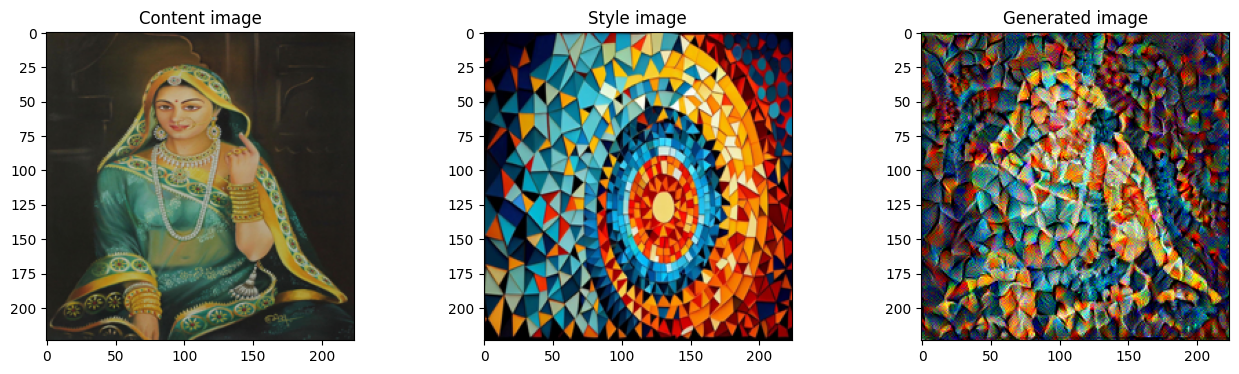

In [28]:

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

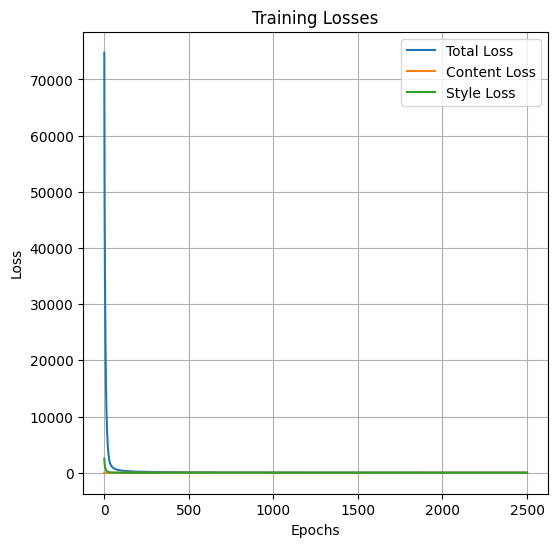

In [29]:
plt.figure(figsize=(6, 6))
plt.plot(total_loss, label='Total Loss')
plt.plot(content_loss, label='Content Loss')
plt.plot(style_loss, label='Style Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.show()